In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

/work2/04703/sravula/frontera/miniconda3/envs/basic/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


# Load the data

In [3]:
root_path = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
chip_num = 9

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=False)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Check the data matrices converted from touchstone to np

In [6]:
print("GT Data shape: ", data_dict['gt_matrix'].shape)
print("VF Data shape: ", data_dict['vf_matrix'].shape)
print("Y Data shape: ", data_dict['y_matrix'].shape)

GT Data shape:  (1000, 4, 4, 2)
VF Data shape:  (1000, 4, 4, 2)
Y Data shape:  (132, 4, 4, 2)


In [7]:
print("GT Data type: ", data_dict['gt_matrix'].dtype)
print("VF Data type: ", data_dict['vf_matrix'].dtype)
print("Y Data type: ", data_dict['y_matrix'].dtype)

GT Data type:  float32
VF Data type:  float32
Y Data type:  float32


In [8]:
print("GT frequency shape: ", data_dict['gt_freqs'].shape)
print("Y frequency shape: ", data_dict['y_freqs'].shape)

GT frequency shape:  (1000,)
Y frequency shape:  (132,)


In [9]:
print("GT frequency type: ", data_dict['gt_freqs'].dtype)
print("Y frequency type: ", data_dict['y_freqs'].dtype)

GT frequency type:  float64
Y frequency type:  float64


## Calc the Singular values to check the distribution

In [10]:
temp = np.empty(data_dict['gt_matrix'].shape[:-1], dtype=np.complex64)
temp.real = data_dict['gt_matrix'][..., 0]
temp.imag = data_dict['gt_matrix'][..., 1]

print("Complex GT data shape: ", temp.shape)
print("Complex GT data type: ", temp.dtype)

Complex GT data shape:  (1000, 4, 4)
Complex GT data type:  complex64


In [11]:
vals = np.linalg.svd(temp, compute_uv=False)
print("GT data singular values shape: ", vals.shape)

GT data singular values shape:  (1000, 4)


In [12]:
vals = vals[:,0]
print("GT data largest singular values shape: ", vals.shape)

GT data largest singular values shape:  (1000,)


In [13]:
print("Max singular value: ", np.amax(vals))
print("Min singular value: ", np.amin(vals))

Max singular value:  1.0
Min singular value:  0.70781934


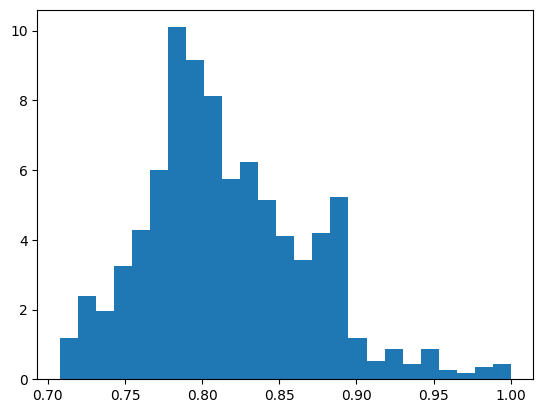

In [14]:
plt.figure()
plt.hist(vals, density=True, bins=25)
plt.show()

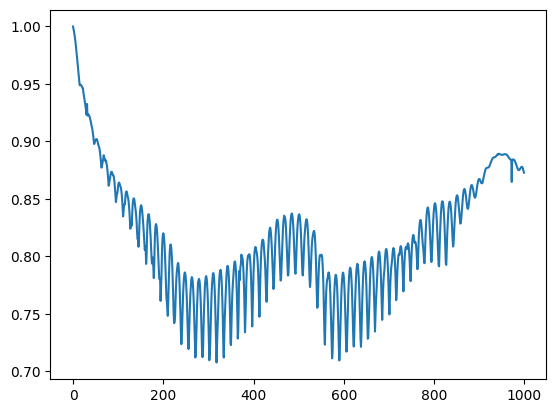

In [15]:
plt.figure()
plt.plot(vals)
plt.show()

## Convert the raw data matrices to only the unique S-parameters

In [16]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

In [17]:
print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1000)
GT S-parameters shape:  (10, 2, 1000)
Y S-parameters shape:  (10, 2, 132)


In [18]:
print("VF S-parameters type: ", vf_data.dtype)
print("GT S-parameters type: ", gt_data.dtype)
print("Y S-parameters type: ", y_data.dtype)

VF S-parameters type:  float32
GT S-parameters type:  float32
Y S-parameters type:  float32


In [19]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

In [20]:
print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1000,)
Y frequencies shape:  (132,)


In [21]:
print("GT frequencies type: ", gt_freqs.dtype)
print("Y frequencies type: ", y_freqs.dtype)

GT frequencies type:  float64
Y frequencies type:  float64


## Plot the Ground truth S-parameters 

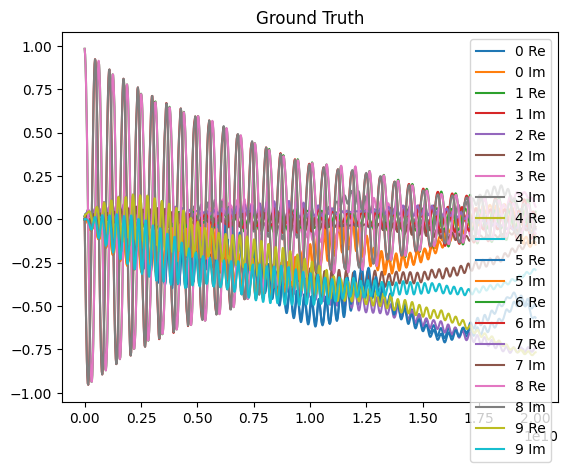

In [22]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.show()

In [23]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print("GT magniutde shape: ", gt_mag.shape)

GT magniutde shape:  torch.Size([10, 1000])


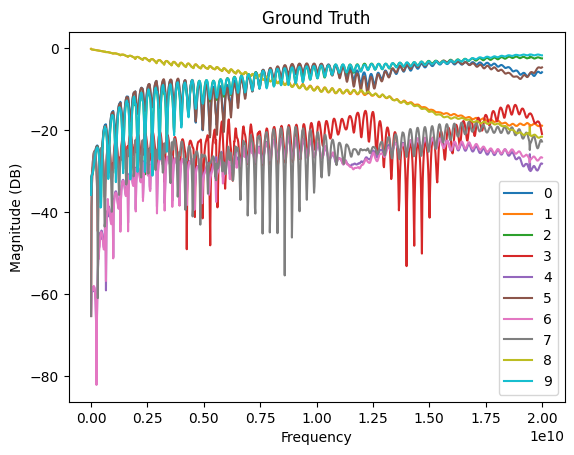

In [24]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

## Check the data for some smoothness and regularity conditions

In [25]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(10, 2, 999)


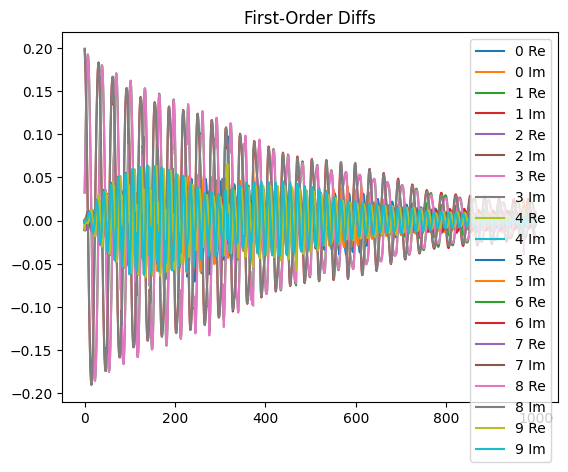

In [26]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("First-Order Diffs")
plt.show()

(10, 2, 998)


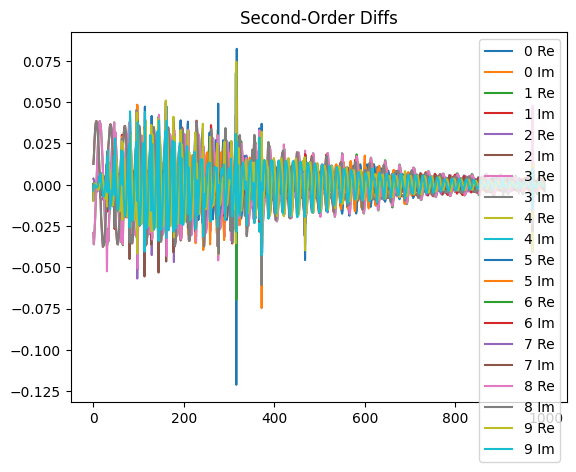

In [27]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Grab some measurements

In [28]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = int(y_freqs.shape[0])

In [29]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [30]:
print("LENGTH: ", LENGTH)
print("Intended M (num measurements): ", M)
print("Actual M (num measurements): ", len(kept_inds))
print("(LENGTH - M): ", len(missing_inds))

LENGTH:  1000
Intended M (num measurements):  132
Actual M (num measurements):  132
(LENGTH - M):  868


## Make the final data

In [31]:
x = torch.from_numpy(gt_data)
x = x.view(-1, LENGTH).unsqueeze(0)

In [32]:
print("Final GT data shape: ", x.shape)
print("Final GT data type: ", x.dtype)

Final GT data shape:  torch.Size([1, 20, 1000])
Final GT data type:  torch.float32


In [33]:
y = torch.clone(x)[:, :, kept_inds]

In [34]:
print("Final Y data shape: ", y.shape)
print("Final Y data type: ", y.dtype)

Final Y data shape:  torch.Size([1, 20, 132])
Final Y data type:  torch.float32


In [35]:
y_freqs = gt_freqs[kept_inds] #NOTE - y_freqs was previously the name of the VF used frequencies, changing it here

In [36]:
print("Final Y frequencies shape: ", y_freqs.shape)
print("Final Y frequencies type: ", y_freqs.dtype)

Final Y frequencies shape:  (132,)
Final Y frequencies type:  float64


## Check the singular values again with the PyTorch function on the S-parameters

In [37]:
vals = utils.sparams_to_sing_vals(x)
vals = vals[:, 0] #grab only the largest singular value

In [38]:
print("Largest sing vals shape: ", vals.shape)

Largest sing vals shape:  torch.Size([1000])


In [39]:
print("Max singular value: ", torch.max(vals).item())
print("Min singular value: ", torch.min(vals).item())

Max singular value:  1.0
Min singular value:  0.7078194618225098


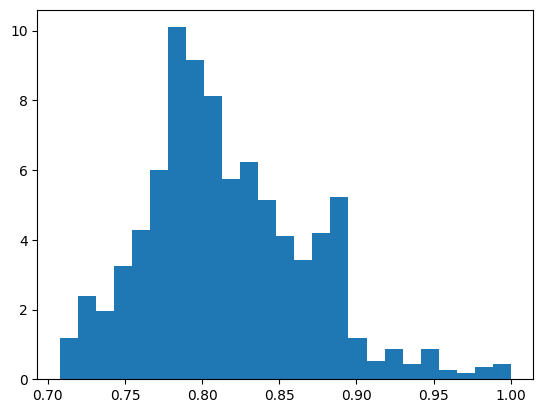

In [40]:
plt.figure()
plt.hist(vals.numpy(), density=True, bins=25)
plt.show()

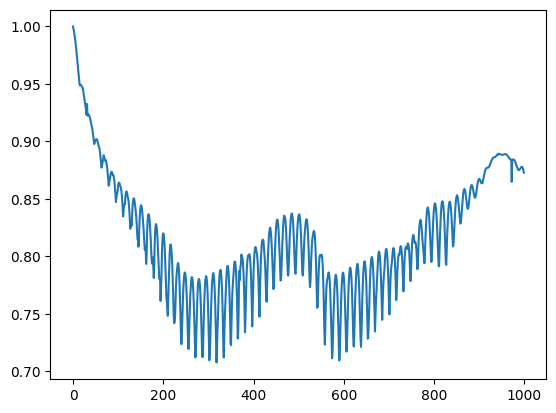

In [41]:
plt.figure()
plt.plot(vals.numpy())
plt.show()

## Check the causaliy of the signal

In [42]:
evens = [i for i in range(x.shape[1]) if i%2 == 0]
odds = [i for i in range(x.shape[1]) if i%2 != 0]
print("Even indices length: ", len(evens))
print("Odd indices length: ", len(odds))

Even indices length:  10
Odd indices length:  10


In [43]:
x_complex = torch.complex(x[:,evens,:], x[:,odds,:])
print("Complex x shape: ", x_complex.shape)

Complex x shape:  torch.Size([1, 10, 1000])


In [44]:
x_time = torch.fft.irfft(x_complex, n=2*x_complex.shape[-1]-1, norm="forward")
print("Time-domain x shape: ", x_time.shape)

Time-domain x shape:  torch.Size([1, 10, 1999])


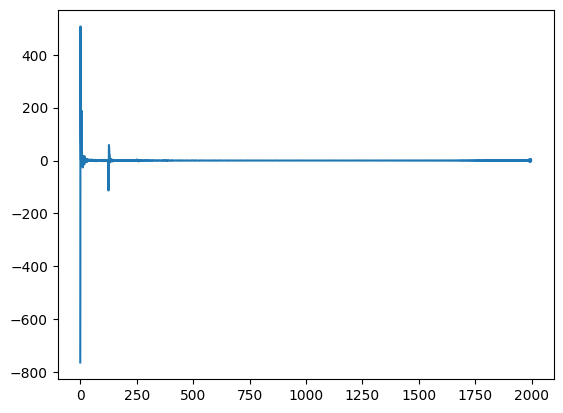

In [45]:
plt.figure()
plt.plot(x_time.cpu().numpy()[0,0,:])
plt.show()

## Try to check the Causality Layer

In [46]:
from model_parts import CausalityLayer

Causal_Layer = CausalityLayer(LENGTH, K=1)
causal_check = Causal_Layer(x[:,evens,:])

In [47]:
print("X shape: ", x.shape)
print("Causal output shape: ", causal_check.shape)

X shape:  torch.Size([1, 20, 1000])
Causal output shape:  torch.Size([1, 20, 1000])


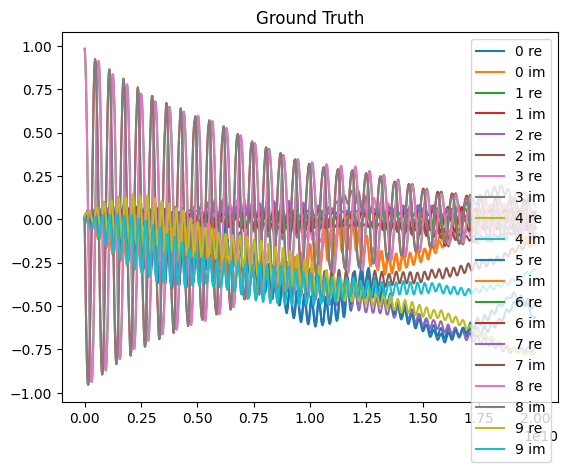

In [48]:
plt.figure()
for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
plt.title("Ground Truth")
if n_sparams <= 10:
    plt.legend()
plt.show()

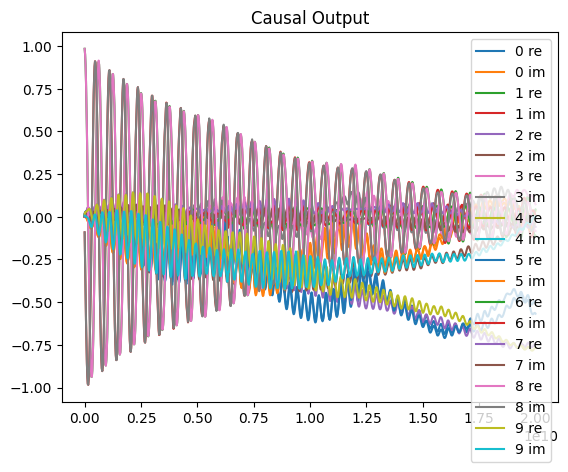

In [49]:
plt.figure()
for j in range(causal_check.shape[0]):
    for i in range(causal_check.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, causal_check[j,i,:].flatten(), label=label)
plt.title("Causal Output")
if n_sparams <= 10:
    plt.legend()
plt.show()

In [50]:
print("MSE between X and causal recon (should be close to 0): ", torch.mean(torch.square(x - causal_check)).item())

MSE between X and causal recon (should be close to 0):  0.0009476638515479863


In [51]:
x_mag = utils.to_mag(x)
causal_mag = utils.to_mag(causal_check)

print("X magnitude shape: ", x_mag.shape)
print("Causal recon magnitude shape: ", causal_mag.shape)

X magnitude shape:  torch.Size([10, 1000])
Causal recon magnitude shape:  torch.Size([10, 1000])


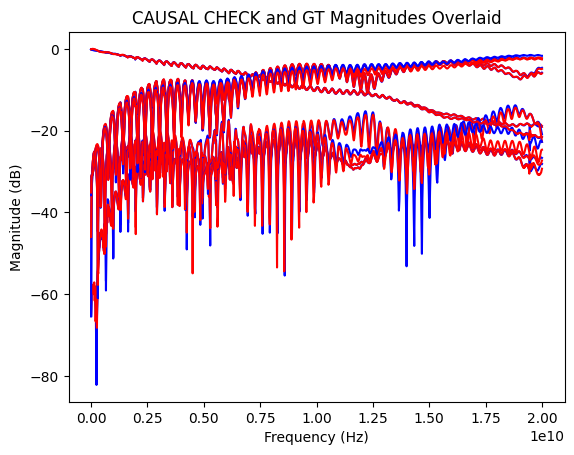

In [52]:
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, causal_mag[i], color="red")

plt.title("CAUSAL CHECK and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Try to check the passivity layer

### First make sure it doesnt change OG signals

In [53]:
from model_parts import PassivityLayer

Passive_Layer = PassivityLayer()
passive_check = Passive_Layer(x)

In [54]:
print("Passivity recon shape: ", passive_check.shape)
print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())

Passivity recon shape:  torch.Size([1, 20, 1000])
MSE between X and passive recon (should be 0):  0.0


### Now scale the OG signal, try to make passive, and compare

In [55]:
x_scaled = 2. * x

In [56]:
print("MSE between X and scaled X: ", torch.mean(torch.square(x - x_scaled)).item())

MSE between X and scaled X:  0.07450834661722183


In [57]:
scaled_vals = utils.sparams_to_sing_vals(x_scaled)
scaled_vals = scaled_vals[:, 0] #grab only the largest singular value

In [58]:
print("Max singular value of scaled X: ", torch.max(scaled_vals).item())
print("Min singular value of scaled X: ", torch.min(scaled_vals).item())

Max singular value of scaled X:  2.0
Min singular value of scaled X:  1.4156389236450195


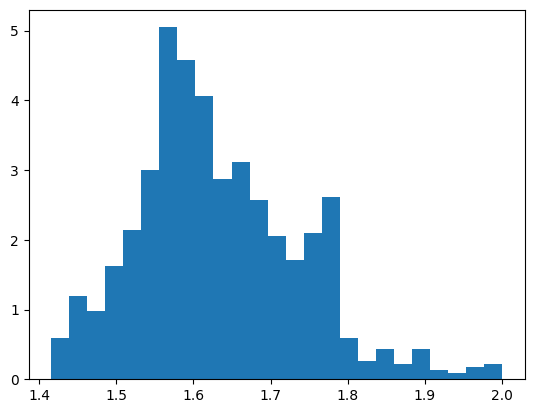

In [59]:
plt.figure()
plt.hist(scaled_vals.numpy(), density=True, bins=25)
plt.show()

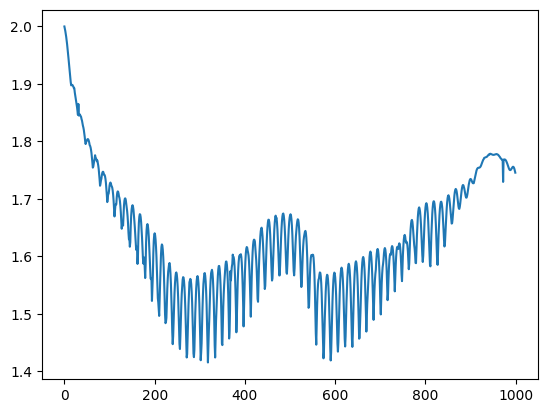

In [60]:
plt.figure()
plt.plot(scaled_vals.numpy())
plt.show()

In [61]:
passive_check = Passive_Layer(x_scaled)

print("Passive recon shape: ", passive_check.shape)
print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())

Passive recon shape:  torch.Size([1, 20, 1000])
MSE between X and passive recon (should be 0):  0.0045206621289253235


In [62]:
passive_vals = utils.sparams_to_sing_vals(passive_check)
passive_vals = passive_vals[:, 0] #grab only the largest singular value

In [63]:
print("Max singular val of passive recon: ", torch.max(passive_vals).item())
print("Min singular val of passive recon: ", torch.min(passive_vals).item())

Max singular val of passive recon:  1.0000005960464478
Min singular val of passive recon:  0.9999994039535522


/work2/04703/sravula/frontera/miniconda3/envs/basic/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/work2/04703/sravula/frontera/miniconda3/envs/basic/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


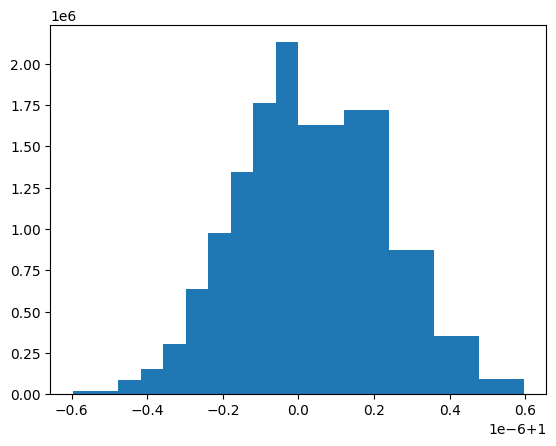

In [64]:
plt.figure()
plt.hist(passive_vals.numpy(), density=True, bins=25)
plt.show()

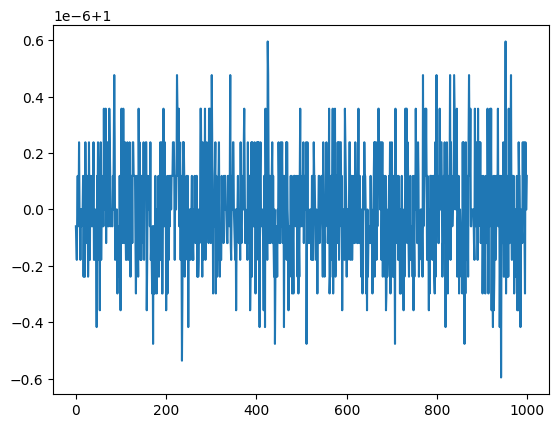

In [65]:
plt.figure()
plt.plot(passive_vals.numpy())
plt.show()

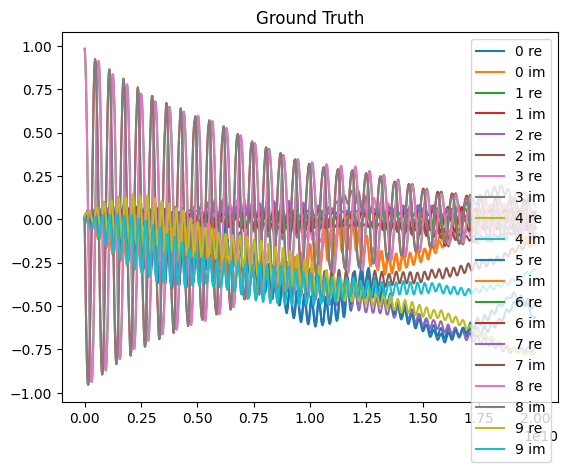

In [66]:
plt.figure()
for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
plt.title("Ground Truth")
if n_sparams <= 10:
    plt.legend()
plt.show()

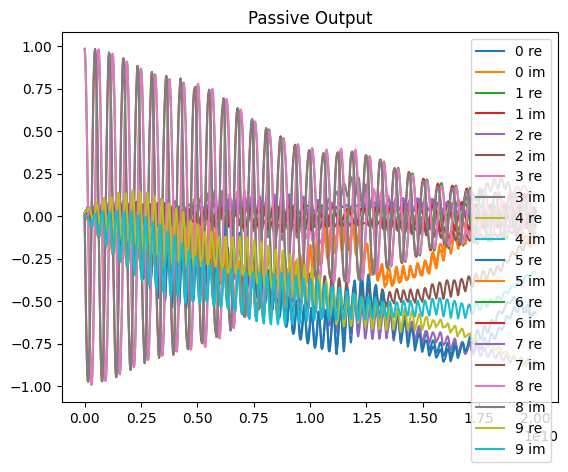

In [67]:
plt.figure()
for j in range(passive_check.shape[0]):
    for i in range(passive_check.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, passive_check[j,i,:].flatten(), label=label)
plt.title("Passive Output")
if n_sparams <= 10:
    plt.legend()
plt.show()

In [68]:
x_mag = utils.to_mag(x)
passive_mag = utils.to_mag(passive_check)

print("X mag shape", x_mag.shape)
print("Passive recon mag shape", passive_mag.shape)

X mag shape torch.Size([10, 1000])
Passive recon mag shape torch.Size([10, 1000])


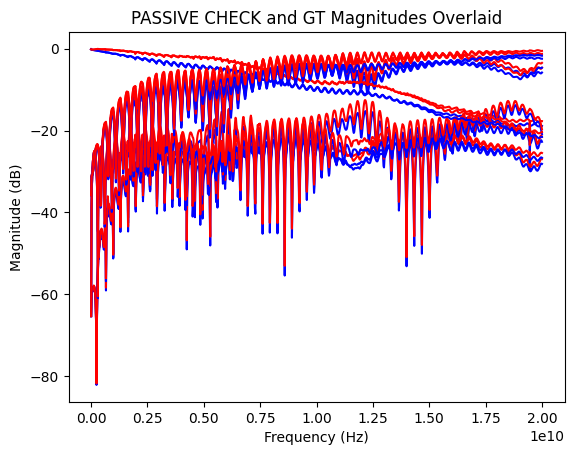

In [69]:
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, passive_mag[i], color="red")

plt.title("PASSIVE CHECK and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

# Set up the network

In [70]:
LR = 1e-4 # learning rate
NUM_ITER = 25000 # number iterations

NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 1

BASE_NGF = 2 ** int(np.ceil(np.log2(NZ)))
BASE_NGF = max(BASE_NGF, 64)
BASE_NGF = min(BASE_NGF, 512)

NGF = [int(BASE_NGF * 2**(i/2)) for i in range(NUM_LAYERS)]

BS = y.shape[0]
NC = y.shape[1]

In [71]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  20
NUM_LAYERS:  9
BASE NGF:  64
NGF:  [64, 90, 128, 181, 256, 362, 512, 724, 1024]
BS:  1
NC:  20


In [72]:
from models import RES_UNET

KERNEL_SIZE = 1
USE_SKIP = False
USE_CAUSAL_PASSIVE = True

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, \
               num_layers=NUM_LAYERS, use_skip=USE_SKIP, causal_passive=USE_CAUSAL_PASSIVE)
net = net.to(device)

In [73]:
test_out = net.forward_with_z()
print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 1000])


In [74]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  8182128


In [75]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name + ": ", param.shape)

encoder.0.input_layer.0.weight:  torch.Size([64, 20, 1])
encoder.0.input_layer.3.weight:  torch.Size([64, 64, 1])
encoder.1.conv_block.2.weight:  torch.Size([90, 64, 1])
encoder.1.conv_block.6.weight:  torch.Size([90, 90, 1])
encoder.2.conv_block.2.weight:  torch.Size([128, 90, 1])
encoder.2.conv_block.6.weight:  torch.Size([128, 128, 1])
encoder.3.conv_block.2.weight:  torch.Size([181, 128, 1])
encoder.3.conv_block.6.weight:  torch.Size([181, 181, 1])
encoder.4.conv_block.2.weight:  torch.Size([256, 181, 1])
encoder.4.conv_block.6.weight:  torch.Size([256, 256, 1])
encoder.5.conv_block.2.weight:  torch.Size([362, 256, 1])
encoder.5.conv_block.6.weight:  torch.Size([362, 362, 1])
encoder.6.conv_block.2.weight:  torch.Size([512, 362, 1])
encoder.6.conv_block.6.weight:  torch.Size([512, 512, 1])
encoder.7.conv_block.2.weight:  torch.Size([724, 512, 1])
encoder.7.conv_block.6.weight:  torch.Size([724, 724, 1])
decoder.0.conv_block.2.weight:  torch.Size([64, 128, 1])
decoder.0.conv_block.5

# Make the linear interpolation and use it as the input to the network

In [76]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [77]:
y_interp = Interpolate(np.arange(LENGTH))

print("Interpolation shape: ", y_interp.shape)

Interpolation shape:  (1, 20, 1000)


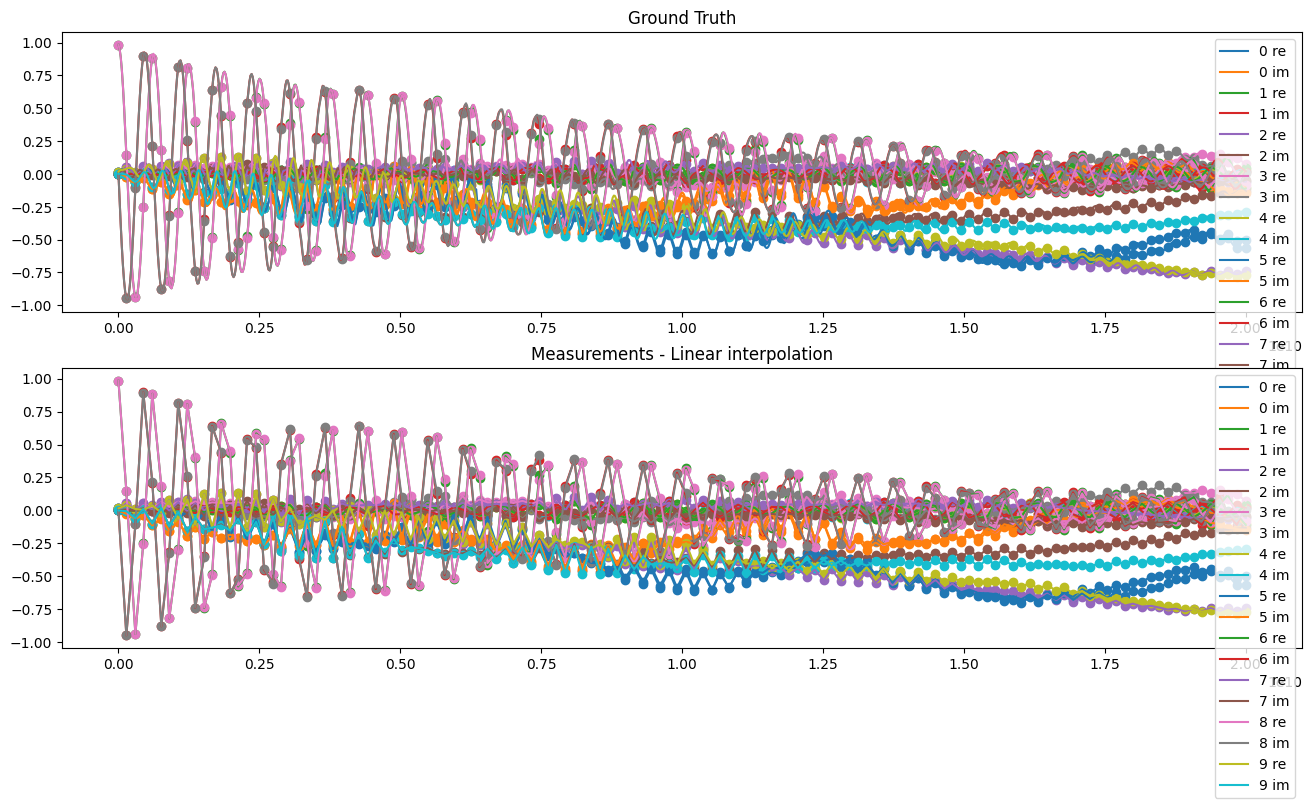

In [78]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [79]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print("Interpolation magnitude shape: ", y_interp_mag.shape)

Interpolation magnitude shape:  torch.Size([10, 1000])


In [80]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print("X magnitude shape: ", x_mag.shape)
print("Y magnitude shape: ", y_mag.shape)

X magnitude shape:  torch.Size([10, 1000])
Y magnitude shape:  torch.Size([10, 132])


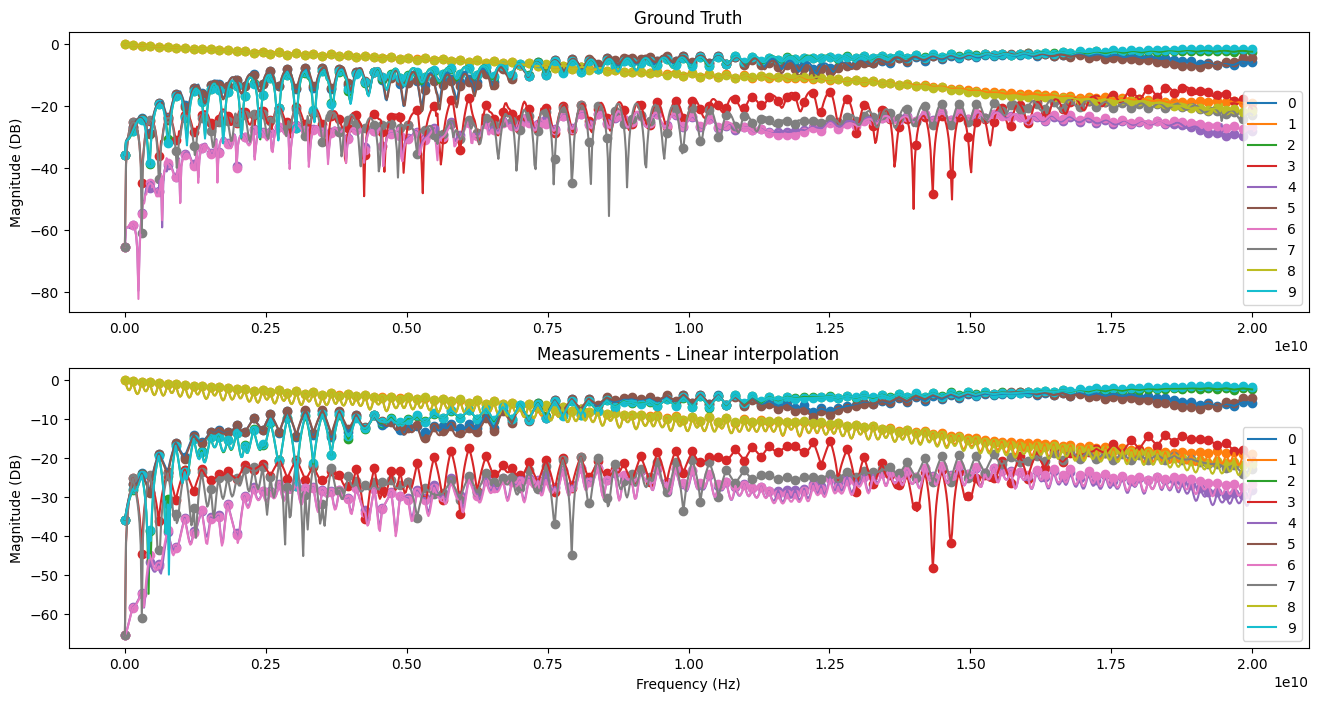

In [81]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[1].legend()

plt.show()

In [82]:
net.set_z(y_interp)

y_interp = torch.from_numpy(y_interp)
y_interp = y_interp.to(device)

# Run

In [83]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

REG_HYPERPARAM = 0.1

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
    regularizer = regularizer.to(device)

In [84]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

x = x.to(device)
y = y.to(device)

In [ ]:
tic = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    
    out = net.forward_with_z()
    
    train_error = criterion(out, y) 
    if REG_HYPERPARAM > 0:
        train_reg = REG_HYPERPARAM * regularizer(out)
        train_loss = train_error + train_reg
    else:
        train_loss = train_error
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        if REG_HYPERPARAM > 0:
            train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

ITER  0
TIME:  0.21061038970947266

ITER  999
TIME:  38.57710099220276

ITER  1999
TIME:  77.07003092765808

ITER  2999
TIME:  115.25016021728516

ITER  3999
TIME:  153.2027997970581

ITER  4999
TIME:  189.46241664886475

ITER  5999
TIME:  225.29553198814392

ITER  6999
TIME:  262.53671765327454

ITER  7999
TIME:  299.34853768348694

ITER  8999
TIME:  335.76377272605896

ITER  9999
TIME:  373.1491205692291

ITER  10999
TIME:  408.82189178466797

ITER  11999
TIME:  444.82892298698425

ITER  12999
TIME:  480.53241300582886

ITER  13999
TIME:  518.4387698173523

ITER  14999
TIME:  556.5406115055084



# Plot the last output and the metrics

In [ ]:
out = out.detach().clone().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
#         axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
#         axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
#         axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [ ]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
#     axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
#     axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
if n_sparams <= 10:
    axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
#     axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

In [ ]:
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, out_mag[i], color="red")

plt.title("DIP and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

In [ ]:
max_idx = 500 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

# Calculate Metrics between DIP, Vector Fit, Linear Interpolation, and the Ground Truth 

In [ ]:
print("FINAL DIP MSE: ", test_mses[-1])
print("LINEAR INTERP MSE: ", torch.nn.MSELoss()(x, y_interp).item())

## Make neworks from DIP, Interp, and Observations

In [ ]:
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)

INTERP_MATRIX = utils.sparams_to_matrix(y_interp)

Y_MATRIX = utils.sparams_to_matrix(y)

In [ ]:
print(DIP_OUT_MATRIX.shape)
print(INTERP_MATRIX.shape)
print(Y_MATRIX.shape)

In [ ]:
DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(chip_num))

INTERP_net = utils.matrix_to_network(INTERP_MATRIX, gt_freqs, "Linear Interpolation With "+str(M)+" Samples for Chip "+str(chip_num))

Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(chip_num))

## Quickly check the singular values of the output

In [ ]:
temp = DIP_net.s

print(temp.shape)
print(temp.dtype)

In [ ]:
vals = np.linalg.svd(temp, compute_uv=False)
print(vals.shape)

In [ ]:
vals = vals[:,0]
print(vals.shape)

In [ ]:
print(np.amax(vals))
print(np.amin(vals))

In [ ]:
plt.figure()
plt.hist(vals, density=True, bins=25)
plt.show

In [ ]:
plt.figure()
plt.plot(vals)
plt.show()

## Grab the data back from the networks for DIP and Interp to compare metrics

In [ ]:
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

INTERP_FINAL_OUT = np.stack((INTERP_net.s.real, INTERP_net.s.imag), axis=-1)

In [ ]:
print(DIP_FINAL_OUT.shape)
print(INTERP_FINAL_OUT.shape)

In [ ]:
dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
interp_data = utils.matrix_to_sparams(INTERP_FINAL_OUT)

In [ ]:
print(dip_data.shape)
print(interp_data.shape)

In [ ]:
print(dip_data.dtype)
print(interp_data.dtype)

## Compare DIP, VF, and Interp

In [ ]:
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

data_range = np.amax(gt_data) - np.amin(gt_data)

psnr_ours = psnr(gt_data, dip_data)#, data_range)
psnr_interp = psnr(gt_data, interp_data)#, data_range)
psnr_vf = psnr(gt_data, vf_data)#, data_range)

In [ ]:
print("DIP PSNR: ", psnr_ours)
print("INTERP PSNR: ", psnr_interp)
print("VF PSNR: ", psnr_vf)

## Save the outputs

In [ ]:
# write_path = "/scratch1/04703/sravula"

# DIP_net.write_touchstone(write_path+"/DIP_"+str(chip_num))
# INTERP_net.write_touchstone(write_path+"/INTERP_"+str(chip_num))
# Y_net.write_touchstone(write_path+"/OBSERVATIONS_"+str(chip_num))